(1, 3, 3)
(5, 3, 1)
(3,)
[[ -1.32272721  -1.01326783]
 [  1.32272721  -1.01326783]
 [ 72.53430523  55.56450146]
 [-72.53430523  55.56450146]
 [ -1.32272721  -1.01326783]]


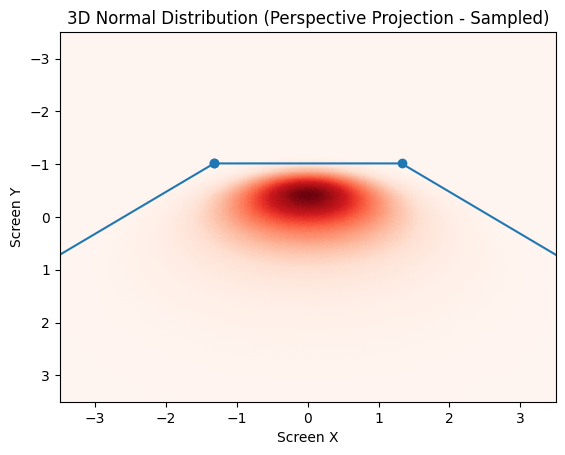

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def perspective_projection(points, projection_matrix):
    """Projects 3D points to 2D using perspective projection."""


    # Convert to homogeneous coordinates
    homogeneous_points = np.concatenate([points, np.ones((points.shape[0], 1))], axis=1)

    # Apply projection
    projected_points = homogeneous_points @ projection_matrix.T

    # Perspective divide
    projected_points = projected_points[:, :2] / projected_points[:, 3:]

    return projected_points

def rotation_matrix_x(angle):
    """Creates a rotation matrix for rotation around the X-axis."""
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c]
    ])

def rotation_matrix_y(angle):
    """Creates a rotation matrix for rotation around the Y-axis."""
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([
        [c, 0, s],
        [0, 1, 0],
        [-s, 0, c]
    ])

def rotation_matrix_z(angle):
    """Creates a rotation matrix for rotation around the Z-axis."""
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([
        [c, -s, 0],
        [s, c, 0],
        [0, 0, 1]
    ])

def get_projection_matrix(fovx, fovy):
  """Constructs a simplified projection matrix."""
  tan_half_fovy = np.tan((fovy / 2))
  tan_half_fovx = np.tan((fovx / 2))

  proj_mat = np.zeros([4, 4])

  proj_mat[0, 0] = 1.0/tan_half_fovx
  proj_mat[1, 1] = 1.0/tan_half_fovy
  proj_mat[3, 3] = 1.0
  proj_mat[2, 2] = 1.0

  return proj_mat


# --- Parameters ---
covariance = [[1., 0.0, 0.0],
              [0.0, 1., 0.0],
              [0.0, 0.0, 0.01]]

z = 2.0
d=3.0
mean = np.array([0, 0, -z])
plane_points = [
                [-d, -d, -z],
                [ d,  -d, -z],
                [ d, d, -z],
                [ -d,  d, -z],
                [-d, -d, -z]]


fov = 60
aspect_ratio = 1
near = 0.1
far = 100
t = near * np.tan(np.radians(fov) / 2.0)
r = t * aspect_ratio
projection_matrix = np.array([
    [near / r, 0, 0, 0],
    [0, near / t, 0, 0],
    [0, 0, -(far + near) / (far - near), -2 * far * near / (far - near)],
    [0, 0, -1, 0]
])

num_samples = 100000000

# --- Rotation ---
rotation_angle_x = np.radians(40)  # Rotate 90 degrees around the X-axis
rotation_angle_y = np.radians(0)
rotation_angle_z = np.radians(0)

rotation_x = rotation_matrix_x(rotation_angle_x)
rotation_y = rotation_matrix_y(rotation_angle_y)
rotation_z = rotation_matrix_z(rotation_angle_z)

# Combine rotations (order matters: first X, then Y, then Z)
rotation_matrix = rotation_z @ rotation_y @ rotation_x


# Rotate the covariance matrix
rotated_covariance = rotation_matrix @ covariance @ rotation_matrix.T

print(rotation_matrix[None,...].shape)
print(np.array(plane_points)[...,None].shape)
print(mean.shape)
# Rotate the plane points
rotated_plane_points = (rotation_matrix[None,...] @ (np.array(plane_points) - mean[None,...])[...,None]).squeeze() + mean[None,...]

# --- Sample from the *Rotated* Distribution ---
samples = multivariate_normal.rvs(mean=mean, cov=rotated_covariance, size=num_samples)


# --- Project the Sampled Points ---
projected_samples = perspective_projection(samples, projection_matrix)
projected_plane_points = perspective_projection(rotated_plane_points, projection_matrix)

projected_samples = projected_samples[np.logical_and(np.abs(projected_samples[:,0])<3.5, np.abs(projected_samples[:,1])<3.5)]
# Option 1: Simple Scatter Plot (for fewer points, shows individual points)
#plt.scatter(projected_samples[:, 0], projected_samples[:, 1], s=0.1, alpha=0.05)

# Option 2: 2D Histogram (better for many points, shows density)
fig, ax = plt.subplots()  # Create the figure and axes


uniform = np.random.uniform(size=(100000, 2))*10 - 5
projected_samples = np.concatenate((uniform, projected_samples), axis=0)
hist = ax.hist2d(projected_samples[:, 0], projected_samples[:, 1], bins=(512, 512), cmap="Reds")

ax.set_xlim(-3.5, 3.5)
ax.set_ylim(3.5, -3.5)

# Add colorbar using the returned histogram object
print(projected_plane_points)
#ax.scatter(projected_plane_points[...,0], projected_plane_points[...,1])
ax.plot(projected_plane_points[...,0], projected_plane_points[...,1], '-o')
#ax.set_aspect(1.0/ax.get_data_ratio())

ax.set_xlabel('Screen X')
ax.set_ylabel('Screen Y')
ax.set_title('3D Normal Distribution (Perspective Projection - Sampled)')

# The following is redundant as set_aspect(1.0) already does this.
# ax.axis('square')  # Ensure square axis - already handled by set_aspect

plt.show()



[[ 1.73205081  0.          0.          0.        ]
 [ 0.          1.73205081  0.          0.        ]
 [ 0.          0.         -1.002002   -0.2002002 ]
 [ 0.          0.         -1.          0.        ]]
-0.20020020020020018
-1.0
[[1.         0.         0.        ]
 [0.         0.59095585 0.48747984]
 [0.         0.48747984 0.41904415]]
[[0.75       0.        ]
 [0.         0.44321689]]


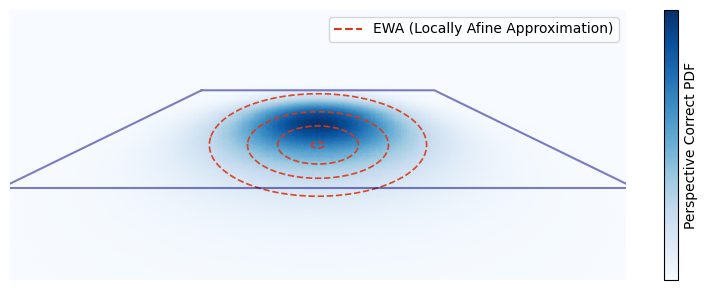

In [8]:

def covariance_2d_jacobian(mean, projection_matrix):
  # Compute the jacobian according to (29) from EWA Volume Splatting M.Zwicker et. al (2001)
  jacobian = np.zeros([3, 3])
  print(projection_matrix)
  print(projection_matrix[2,3])
  print(projection_matrix[3,2])
  jacobian[0, 0] = projection_matrix[0,0]/(projection_matrix[3,2]*mean[2])
  jacobian[0, 2] = (projection_matrix[0,0]*mean[0]/projection_matrix[3,2])*(-1.0/(mean[2]*mean[2]))
  jacobian[1, 1] = projection_matrix[1,1]/(projection_matrix[3,2]*mean[2])
  jacobian[1, 2] = (projection_matrix[1,1]*mean[1]/projection_matrix[3,2])*(-1.0/(mean[2]*mean[2]))
  jacobian[2, 0] = 0.0
  jacobian[2, 1] = 0.0
  jacobian[2, 2] = (projection_matrix[2,3]/projection_matrix[3,2])*(-1.0/(mean[2]*mean[2]))

  return jacobian

J = covariance_2d_jacobian(mean, projection_matrix)
cov = (J@rotated_covariance@J.T)[:2,:2]
print(rotated_covariance)
print(cov)

rv = multivariate_normal(mean[:2], cov)
x, y = np.mgrid[-3:3:.02, -3:3:.02]
pos = np.dstack((x, y))
pdf = rv.pdf(pos)



fig, ax = plt.subplots(figsize=(8, 3))  # Adjust figure size as needed

# 2D Histogram (Heatmap)
hist = ax.hist2d(projected_samples[:, 0], projected_samples[:, 1], bins=(512, 512), cmap="Blues")


# Contour Lines
levels = [0.1, 0.18, 0.24, 0.275]
contour = ax.contour(x, y, pdf, levels=levels,
                     colors="#DC3912",
                     linewidths=1.24, alpha=0.9, linestyles='--')  # More distinct colors, linewidths, alpha

# Create a proxy artist for the legend (same as before)
legend_line = plt.Line2D([], [], color="#DC3912", linewidth=1.5, linestyle='--')

# Add the legend (same as before)
ax.legend([legend_line], ["EWA (Locally Afine Approximation)"], loc="best") # Replace "Contour Description"

# Set plot limits
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(2.5, -2.5)

# Colorbar for the heatmap (important for understanding the density)
cbar = fig.colorbar(hist[3], ax=ax, label="Perspective Correct PDF") # Add a colorbar and label it
cbar.minorticks_off()
# REMOVE COLORBAR TICKS AND LABELS
cbar.set_ticks([])  # Remove all ticks
#cbar.set_label("", labelpad=-1) # Remove the label, and adjust padding if necessary


ax.plot(projected_plane_points[...,0], projected_plane_points[...,1], color="navy", alpha=0.5, linestyle='-', linewidth=1.5)
ax.plot(np.array([-3.5, 3.5]), np.array([0.8, 0.8]), color="navy", alpha=0.5, linestyle='-', linewidth=1.5)

# Add a grid (optional, but can improve readability)
# ax.grid(True, linestyle='--', alpha=0.3)

# Make the plot look cleaner
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0, label1On=False, label2On=False) # label1On and label2On for left and right y axis labels

# Show the plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
#plt.show()
plt.savefig('ewa_plot.png', dpi=300)


[[ 1.73205081  0.          0.          0.        ]
 [ 0.          1.73205081  0.          0.        ]
 [ 0.          0.         -1.002002   -0.2002002 ]
 [ 0.          0.         -1.          0.        ]]
-0.20020020020020018
-1.0
[[1.         0.         0.        ]
 [0.         0.125808   0.31817987]
 [0.         0.31817987 0.884192  ]]
[[0.12       0.        ]
 [0.         0.01509696]]


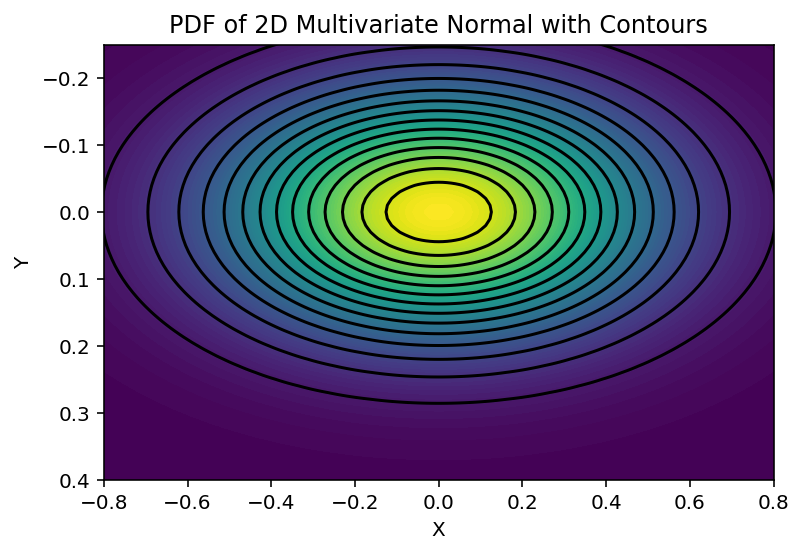

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

J = covariance_2d_jacobian(mean, projection_matrix)
cov = (J@rotated_covariance@J.T)[:2,:2]
print(rotated_covariance)
print(cov)

# Create a grid of points to evaluate the PDF


rv = multivariate_normal(mean[:2], cov)
pdf = rv.pdf(pos)

# Filled contour plot for the PDF
plt.contourf(x, y, pdf, levels=100)

# Add 2-3 distinct contour lines on top
levels = 15  # Choose the levels for your contours
cs = plt.contour(x, y, pdf, levels=levels, colors='black')

plt.xlim(-0.8, 0.8)
plt.ylim(0.4, -0.25)


plt.xlabel('X')
plt.ylabel('Y')
plt.title('PDF of 2D Multivariate Normal with Contours')
plt.show()